# Preface

Ada 1 folder, "reviews". Isinya datasets masih pisah-pisah. Nanti di combine di section "2. Testing with half-done".

Section "2. Testing with datasets...":
- Result combined nya jadi `compiled_reviews.csv`.
- Karena Date masih belum sesuai yang diinginin, aku nyoba pakek regex + timedelta dengan referensi waktu kapan code itu dijalanin. Succeeded.
- Aku include relevant columns aja di dataframe `cleaned_df`.

Section "3. Attempt prepro..."
- Aku redefine lagi functionnya, tapi tambahan sedikit exception/negasi. Ada file `exception_words.json` yang aku pakek untuk nge list kata-kata apa yang gak di process sebagai stopwords. Jadi kata-kata di file itu gak akan terhapus nanti. Mungkin bisa ditambahin nantinya.

Section 4. Attempt EDA
- Bisa kalian coba2 lagi. So far masih wordcloud dan bigrams/trigrams

Section 5. Attempt Feature Preps...
- Kalo mau coba modeling, langsung aja ke bagian ini. Rencana akan ada tokenizer juga di sini, sebelum modeling.



In [1]:
import pandas as pd
import asyncio
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import contractions
from googletrans import Translator
import json
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import nest_asyncio
nest_asyncio.apply()


In [2]:
# Init Bahasa Indonesia stopwords
stpwds_id = stopwords.words('indonesian')

# init Sastrawi stemmer for Bahasa Indonesia
factory = StemmerFactory()
stemmer_id = factory.create_stemmer()

In [3]:
translator = Translator()

In [4]:
# Load the slang dictionary
with open('slang_bank.json', 'r') as file:
    slang_dict = json.load(file)

---

---

# Skip aja part ini, testing doang

In [5]:
async def text_preprocessing_id(text):
    
    # Translate to Bahasa Indonesia
    
    try:
        translated = await translator.translate(text, src='auto', dest='id')
        text = translated.text
    except Exception as e:
        print(f"Translation failed: {e}")
        return None  # Drop text if translation fails
    
    # Expand contractions
    text = contractions.fix(text)

    # Case folding
    text = text.lower()

    # Mention removal
    text = re.sub(r"@[A-Za-z0-9_]+", " ", text)

    # Hashtag removal
    text = re.sub(r"#[A-Za-z0-9_]+", " ", text)

    # Newline removal (\n)
    text = re.sub(r"\\n", " ", text)

    # Whitespace removal
    text = text.strip()

    # URL removal
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"www.\S+", " ", text)

    # Non-letter removal (retain apostrophes)
    text = re.sub(r"[^A-Za-z\s']", " ", text)
    
    # repeat letter removal
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Tokenization
    tokens = word_tokenize(text)
    
    # Slang words replacement
    tokens = [slang_dict[word] if word in slang_dict else word for word in tokens]

    # Stopwords removal
    tokens = [word for word in tokens if word not in stpwds_id or word in {"tidak", "belum", "jangan", "enggak", "gak"}]

    # Stemming (using Sastrawi for Bahasa Indonesia)
    tokens = [stemmer_id.stem(word) for word in tokens]

    # Combine tokens
    text = ' '.join(tokens)

    return text


In [6]:
# samples
sample_reviews_id = [
    "Pengiriman sangat lambat dan pegawai tidak ramah. #mengecewakan",
    "Pelayanan sangat baik! Cepat dan murah. Sangat direkomendasikan.",
    "Saya harus menunggu 3 jam di gudang. @perusahaan tidak bisa diterima!",
    "Can you be like the others? I'm very disappointed with your services.",
    "Kntl", 
    """He! sby-mlg perjalanan mosok iyo 3 hari. mau dikirim dari jam 7 pagi. jarak warehouse kerumah naik sepeda motor 5 menit!!!! yo wes seharian gak ono kabar
ngerti gak, expedisi lain dikasih kontak kurirnya! ini opooo -_-
ujung e gagal kirim !
dari jaman gak ada shopee tokped sek bermasalah ae
tutup ae gak akan bertahan yoan mending wahana/jnt terutama tiki /shopee express

shopee ngasih kompensasi gak tepat waktu gara2 kerjomu ngerti gak
kerja nyari berkah iki nyari dihujat orang kok yo iso makan keringat hasil grundelan e orang -_-

bubar ae gak guna

wes lah besok2 dapat jne mending dibatalno ae -_-
    """,
    "Kntl asu, pukimak, babi, bubar ae cok. Gak guna!",
    "Kulo kok rada kecewa kaliyan pelayanan kurir punika. Paket sing mesthine tekan sesuk, malah telat tekan nganti 3 dinten. Sing langkung parah, paket punika mboten dipunparingi kabar punapa-punapa, lan kulo kedah ngontak layanan pelanggan piyambak.",
    "Apo jo kurir kini? Jan langsuang kasiah barek! Paket nan awak kirim tibo-tibo ado di mana, lapau indak jelas, tarang tuan-tuan indak ado kabar! Jan ambo baliak-baliak mangecek ka call center, malah awak pulo nan mangambek! Cakak bana pelayanannyo, indak ado adab! Awak bayia mahal-mahal, alah kironyo mah pelayanan macam indak ado otak! Tolong lah, jangan macam ini lai ke depan",
    "JNE pungo, hana utak, hanjeut meupike gob rugo, lage bui…😂😂",
    "Jne paleh lehoho kah me barang , ka pike hayeu tat kah nyan. Ok me jih keuh. Kon kah manteng hayeu! lhe lom expedisi selain kah."
]

# make dataframe
df_test_id = pd.DataFrame(sample_reviews_id, columns=["review"])

# 

In [7]:
# apply text preprocessing
# df_test_id["processed_review"] = df_test_id["review"].apply(text_preprocessing_id)

In [8]:
# Async loop to process reviews
async def process_reviews():
    df_test_id["processed_review"] = await asyncio.gather(
        *[text_preprocessing_id(text) for text in df_test_id["review"]]
    )

In [9]:
await process_reviews()

In [ ]:
# Display the original and processed reviews
df_test_id

In [ ]:
pd.set_option('display.max_colwidth', None)

# Display the original and processed reviews
df_test_id

---

# 1. (Skip aja) testing with sample scrapped

In [12]:
# load the dataset
df = pd.read_csv('test.csv')

In [ ]:
df

In [ ]:
df['Rating'].value_counts()

In [15]:
# devide bad and good reviews
## bad reviews = 1 - 3 stars
## good reviews = 4 - 5 stars

bad_reviews_df = df[df['Rating'] <= 3]
good_reviews_df = df[df['Rating'] > 3]

In [ ]:
df['Reviews'][df['Reviews'] == 'No review found'].count()

In [ ]:
bad_reviews_df

In [18]:
# drop rows with 'No review found'
bad_reviews_df = bad_reviews_df[bad_reviews_df['Reviews'] != 'No review found']

In [ ]:
bad_reviews_df

In [20]:
bad_reviews_df_prepo = bad_reviews_df.copy()
async def preprocess_reviews():
    bad_reviews_df_prepo['processed_review'] = await asyncio.gather(
        *[text_preprocessing_id(review) for review in bad_reviews_df_prepo['Reviews']]
    )

await preprocess_reviews()

In [ ]:
bad_reviews_df_prepo

---

# 2. Testing scraped datasets
Untuk script combining berbagai datasets, dan bersih-bersih. Kayak transform date ke date type.

In [ ]:
# combine the datasets
# Define the folder path
folder_path = './reviews'

# Initialize an empty list to store dataframes
dataframes = []

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):  # Check if the file is a CSV
        file_path = os.path.join(folder_path, file_name)
        # Read the CSV file into a dataframe
        df = pd.read_csv(file_path)
        # Optionally add a column to track the source file
        df['Source'] = file_name
        # Append the dataframe to the list
        dataframes.append(df)

# Combine all dataframes into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

# Save the combined dataframe to a CSV file
output_path = 'compiled_reviews.csv'
combined_df.to_csv(output_path, index=False)

print(f"Combined dataframe saved to {output_path}")


In [23]:
final_df = pd.read_csv('compiled_reviews.csv')

In [ ]:
final_df

In [25]:
# remove rows with 'No review found'
final_df = final_df[final_df['Reviews'] != 'No review found']

In [ ]:
final_df.shape

In [ ]:
final_df.isnull().sum()

In [ ]:
# # fill nan values in Date column with "6 months ago"
# final_df['Date'] = final_df['Date'].fillna('6 months ago')

# Calculate the mode of the 'Date' column
mode_value = final_df['Date'].mode()[0]

# Fill NaN values in the 'Date' column with the mode
final_df['Date'] = final_df['Date'].fillna(mode_value)

In [ ]:
final_df.isna().sum()

In [ ]:
final_df

In [31]:
# let's translate the Date column to bahasa indonesia first
## def func to tran
async def translate_to_indonesian_async(text):
    try:
        translated = await translator.translate(text, src='auto', dest='id')
        return translated.text
    except Exception as e:
        print(f"Translation error: {e}")
        return text

In [32]:
async def translate_column(df, column_name):
    tasks = [translate_to_indonesian_async(text) for text in df[column_name]]
    translated_texts = await asyncio.gather(*tasks)
    df[f"{column_name}_translated"] = translated_texts

In [ ]:
await translate_column(final_df, "Date")

In [ ]:
final_df

In [35]:
# let's attempt to transform the date
## def the func

def parse_time_ago(time_ago):
    current_time = datetime.now()
    
    # Match cases with explicit numbers
    match = re.match(r"(\d+)\s+(\w+)", time_ago)
    if match:
        value, unit = int(match.group(1)), match.group(2)
    else:
        # Handle "sehari", "seminggu", "sebulan", "setahun" cases
        if time_ago.startswith('se'):
            value, unit = 1, time_ago.split()[0][2:]  # Extract the unit after "se"
        else:
            return None  # If it doesn't match any known format, return None
    
    # Map units to timedelta
    if unit.startswith('menit'):
        return current_time - timedelta(minutes=value)
    elif unit.startswith('jam'):
        return current_time - timedelta(hours=value)
    elif unit.startswith('hari'):
        return current_time - timedelta(days=value)
    elif unit.startswith('minggu'):
        return current_time - timedelta(weeks=value)
    elif unit.startswith('bulan'):
        # Approximate 1 month = 30 days
        return current_time - timedelta(days=value * 30)
    elif unit.startswith('tahun'):
        # Approximate 1 year = 365 days
        return current_time - timedelta(days=value * 365)
    return None


In [ ]:
final_df['parsed_date'] = final_df['Date_translated'].apply(parse_time_ago)

In [ ]:
final_df

In [ ]:
final_df.info()

In [ ]:
final_df

In [ ]:
final_df.columns

In [41]:
# make copy with relevant columns
cleaned_df = final_df[['Rating', 'Reviews', 'Company', 'Province', 'parsed_date']]

In [ ]:
cleaned_df

In [43]:
# Standardize column names
cleaned_df.columns = cleaned_df.columns.str.strip().str.lower().str.replace(' ', '_')

In [ ]:
cleaned_df.info()

In [ ]:
cleaned_df.duplicated().sum()

In [ ]:
cleaned_df[cleaned_df.duplicated()]

In [ ]:
# drop dupes
cleaned_df.drop_duplicates(inplace=True)

In [ ]:
cleaned_df.duplicated().sum()

In [49]:
cleaned_df.to_csv('cleaned_reviews.csv', index=False)

---

# 3. Attempt preprocessing

In [5]:
with open('exception_words.json', 'r') as file:
    exception_data = json.load(file)

# Extract the list of exception words
exception_words = set(exception_data["exception_words"])

In [6]:
with open('cleaned_reviews.csv', 'r') as file_cleaned:
    bersih_df = pd.read_csv(file_cleaned)

In [7]:
bersih_df

,rating,reviews,company,province,parsed_date
0,5,"Located at the Padang Old City area, just arou...",JNE,Aceh,2024-04-25 11:26:09.540805
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21 11:26:09.540805
2,5,"Nice Place, they're working on rebuild their o...",JNE,Aceh,2022-01-21 11:26:09.540805
3,5,Good delivery service for customers in this co...,JNE,Aceh,2023-01-21 11:26:09.540805
4,5,Good service,JNE,Aceh,2022-01-21 11:26:09.540805
...,...,...,...,...,...
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625
17662,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625


In [8]:
## reinit just to make sure

# Init Bahasa Indonesia stopwords
stpwds_id = stopwords.words('indonesian')

# init Sastrawi stemmer for Bahasa Indonesia
factory = StemmerFactory()
stemmer_id = factory.create_stemmer()

translator = Translator()

In [9]:
# Load the slang dictionary
with open('slang_bank.json', 'r') as file:
    slang_dict = json.load(file)

In [10]:
# Load additional stopwords
with open('expand_stopwords.json', 'r') as f:
    data = json.load(f)

# Ensure the key exists and is a list
custom_stopwords = data.get("expand_stopwords", [])
if not isinstance(custom_stopwords, list):
    raise ValueError("The 'expand_stopwords' key must contain a list.")

# Combine and ensure uniqueness
stpwds_id = set(stpwds_id)  # Convert existing stopwords to a set if not already
stpwds_id.update(custom_stopwords)  # Add new stopwords from the custom list

In [11]:
# let's redefine the func. cs it's so far above there....

async def text_preprocessing_id(text):
    
    # Translate to Bahasa Indonesia
    
    try:
        translated = await translator.translate(text, src='auto', dest='id')
        text = translated.text
    except Exception as e:
        print(f"Translation failed: {e}")
        return None  # Drop text if translation fails
    
    # Expand contractions
    text = contractions.fix(text)

    # Case folding
    text = text.lower()

    # Mention removal
    text = re.sub(r"@[A-Za-z0-9_]+", " ", text)

    # Hashtag removal
    text = re.sub(r"#[A-Za-z0-9_]+", " ", text)

    # Newline removal (\n)
    text = re.sub(r"\\n", " ", text)

    # Whitespace removal
    text = text.strip()

    # URL removal
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"www.\S+", " ", text)

    # Non-letter removal (retain apostrophes)
    text = re.sub(r"[^A-Za-z\s']", " ", text)
    
    # repeat letter removal
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Tokenization
    tokens = word_tokenize(text)
    
    # Slang words replacement
    tokens = [slang_dict[word] if word in slang_dict else word for word in tokens]

    # Stopwords removal
    ## btw itu bisa kalian bikin dict sendiri (.json , maybe).
    tokens = [word for word in tokens if word not in stpwds_id or word in exception_words]

    # Stemming (using Sastrawi for Bahasa Indonesia)
    tokens = [stemmer_id.stem(word) for word in tokens]

    # Combine tokens
    text = ' '.join(tokens)

    return text

In [12]:
# run it!
async def preprocess_reviews():
    bersih_df['processed_reviews'] = await asyncio.gather(
        *[text_preprocessing_id(review) for review in bersih_df['reviews']]
    )

await preprocess_reviews()

In [13]:
bersih_df

,rating,reviews,company,province,parsed_date,processed_reviews
0,5,"Located at the Padang Old City area, just arou...",JNE,Aceh,2024-04-25 11:26:09.540805,letak kawasan kota tua padang jembatan siti nu...
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21 11:26:09.540805,layan buruk langgan alam ambil jasa kirim kelu...
2,5,"Nice Place, they're working on rebuild their o...",JNE,Aceh,2022-01-21 11:26:09.540805,bagus upaya bangun kantor orang orang hebat layan
3,5,Good delivery service for customers in this co...,JNE,Aceh,2023-01-21 11:26:09.540805,kirim langgan negara
4,5,Good service,JNE,Aceh,2022-01-21 11:26:09.540805,layan bagus
...,...,...,...,...,...,...
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625,kargo lambat
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625,lambat cembret
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625,lambat
17662,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625,keras


In [14]:
bersih_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17664 entries, 0 to 17663
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rating             17664 non-null  int64 
 1   reviews            17664 non-null  object
 2   company            17664 non-null  object
 3   province           17664 non-null  object
 4   parsed_date        17664 non-null  object
 5   processed_reviews  17664 non-null  object
dtypes: int64(1), object(5)
memory usage: 828.1+ KB


In [15]:
# Ensure the 'parsed_date' column is in datetime format
bersih_df['parsed_date'] = pd.to_datetime(bersih_df['parsed_date'])

# Extract only the date (remove the time)
bersih_df['parsed_date'] = bersih_df['parsed_date'].dt.date

In [16]:
bersih_df

,rating,reviews,company,province,parsed_date,processed_reviews
0,5,"Located at the Padang Old City area, just arou...",JNE,Aceh,2024-04-25,letak kawasan kota tua padang jembatan siti nu...
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21,layan buruk langgan alam ambil jasa kirim kelu...
2,5,"Nice Place, they're working on rebuild their o...",JNE,Aceh,2022-01-21,bagus upaya bangun kantor orang orang hebat layan
3,5,Good delivery service for customers in this co...,JNE,Aceh,2023-01-21,kirim langgan negara
4,5,Good service,JNE,Aceh,2022-01-21,layan bagus
...,...,...,...,...,...,...
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21,kargo lambat
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21,lambat cembret
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21,lambat
17662,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-21,keras


In [17]:
# check nulls
bersih_df[bersih_df['processed_reviews'] == '']

,rating,reviews,company,province,parsed_date,processed_reviews
10,5,Ok,JNE,Aceh,2022-01-21,
15,5,24jam ready,JNE,Aceh,2020-01-22,
17,5,Great,JNE,Aceh,2019-01-22,
21,5,Ok,JNE,Aceh,2020-01-22,
23,4,Ok,JNE,Aceh,2020-01-22,
...,...,...,...,...,...,...
17444,1,Barang dari tanggal 1 sampe skrg belom terima ...,Sicepat,Sumatera Selatan,2021-01-21,
17445,5,baik,Sicepat,Sumatera Selatan,2021-01-21,
17464,1,babu,Sicepat,Sumatera Selatan,2021-01-21,
17643,1,Paket saya tambah jauh.,Sicepat,Sumatera Utara,2021-01-21,


In [18]:
bersih_df['rating'].value_counts()

rating
1    12456
5     2783
4      954
2      764
3      707
Name: count, dtype: int64

In [19]:
bersih_df.to_csv('prepro_cleaned_reviews.csv', index=False)

---

# 4. Attempt EDA

In [20]:
with open('prepro_cleaned_reviews.csv', 'r') as file_prepro:
    eda_df = pd.read_csv(file_prepro)

In [21]:
eda_df['company'].value_counts()

company
JNE        7164
JNT        6545
Sicepat    3955
Name: count, dtype: int64

In [22]:
# Split DataFrame based on reviews column
jelek_eda_df = eda_df[eda_df['rating'] <= 3]  # Bad ratings (1 - 3)
bagus_eda_df = eda_df[eda_df['rating'] >= 4]  # Good ratings (4 or 5)

print(f"Bad reviews count: {jelek_eda_df.shape[0]}")
print(f"Good reviews count: {bagus_eda_df.shape[0]}")

Bad reviews count: 13927
Good reviews count: 3737


In [23]:
# Kalo mau per company, bagi tiga dulu: JNE, jnt, sicepat
jne_df = jelek_eda_df[jelek_eda_df['company'].str.lower() == 'jne']
jnt_df = jelek_eda_df[jelek_eda_df['company'].str.lower() == 'jnt']
sicepat_df = jelek_eda_df[jelek_eda_df['company'].str.lower() == 'sicepat']

In [24]:
jelek_eda_df

,rating,reviews,company,province,parsed_date,processed_reviews
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21,layan buruk langgan alam ambil jasa kirim kelu...
7,1,Too slow,JNE,Aceh,2016-01-23,lambat
18,2,Slow service,JNE,Aceh,2022-01-21,lambat
20,1,Bad service,JNE,Aceh,2019-01-22,buruk
24,1,The courier was too slow for many reasons even...,JNE,Aceh,2025-01-06,kurir lambat kira pakai sayang m
...,...,...,...,...,...,...
17658,1,Lambat,Sicepat,Sumatera Utara,2021-01-21,lambat
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21,kargo lambat
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21,lambat cembret
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21,lambat


## a. wordcloud

In [25]:
# Function to generate and display word clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

In [26]:
# gak boleh ada naan ternyata...

# Replace NaN with an empty string and ensure all values are strings
jne_df['processed_reviews'] = jne_df['processed_reviews'].fillna('').astype(str)
jnt_df['processed_reviews'] = jnt_df['processed_reviews'].fillna('').astype(str)
sicepat_df['processed_reviews'] = sicepat_df['processed_reviews'].fillna('').astype(str)

jelek_eda_df['processed_reviews'] = jelek_eda_df['processed_reviews'].fillna('').astype(str)

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_2280\1329673354.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jne_df['processed_reviews'] = jne_df['processed_reviews'].fillna('').astype(str)
C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_2280\1329673354.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jnt_df['processed_reviews'] = jnt_df['processed_reviews'].fillna('').astype(str)
C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_2280\1329673354.py:6: SettingWithCopyWar

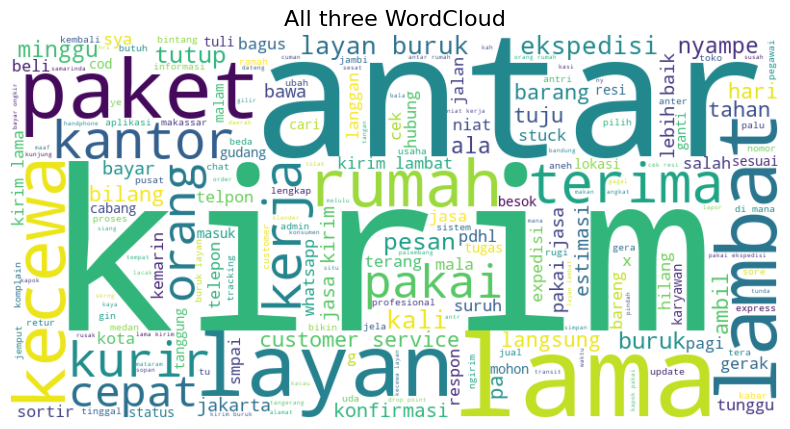

In [27]:
generate_wordcloud(jelek_eda_df['processed_reviews'], 'All three WordCloud')

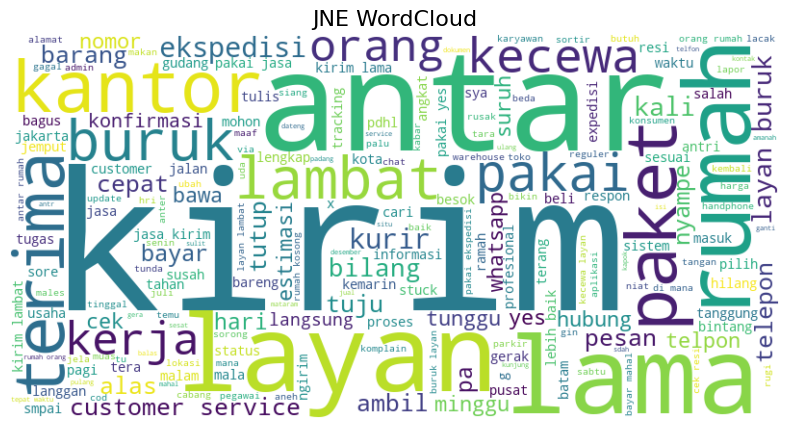

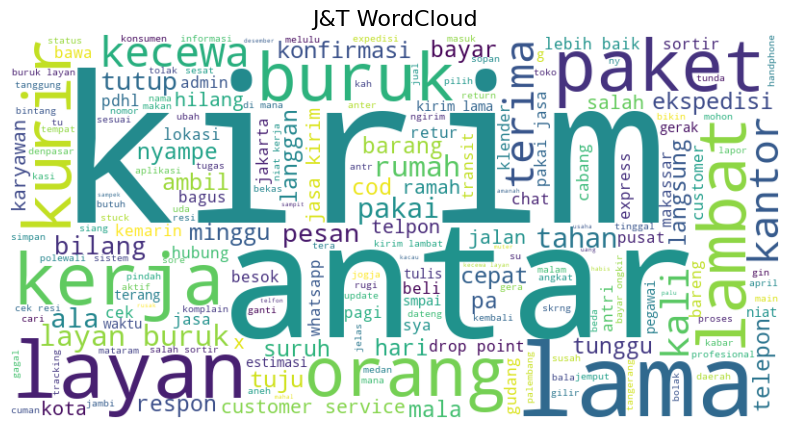

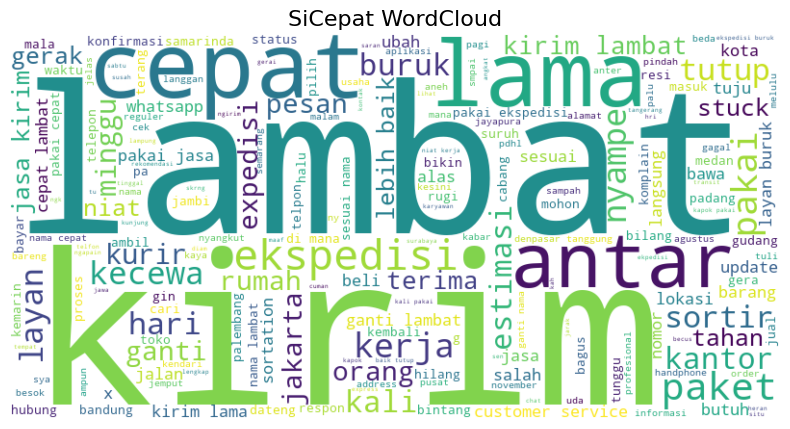

In [28]:
# Generate word clouds for each company
generate_wordcloud(jne_df['processed_reviews'], 'JNE WordCloud')
generate_wordcloud(jnt_df['processed_reviews'], 'J&T WordCloud')
generate_wordcloud(sicepat_df['processed_reviews'], 'SiCepat WordCloud')

In [29]:
# check most used stopwords
## def function

def analyze_most_used_words(df, column, top_n=20):
    '''
    Check n top_n of most common words used.
    df = data
    column = column to be processed
    top_n = show top n words 
    '''
    # Tokenize the column into words
    df['words_list'] = df[column].apply(lambda x: str(x).split())
    
    # Flatten the list of lists and count word frequencies
    word_counts = Counter([word for words in df['words_list'] for word in words])
    
    # Create a DataFrame with the top N most common words
    most_common_df = pd.DataFrame(word_counts.most_common(top_n), columns=['word', 'count'])
    
    # Display the table with a gradient background for visualization
    return most_common_df.style.background_gradient(cmap='Blues')

In [30]:
print("Most Used Words for all three:")
analyze_most_used_words(jelek_eda_df, 'processed_reviews')

Most Used Words for all three:


C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_2280\1013743734.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['words_list'] = df[column].apply(lambda x: str(x).split())


,word,count
0,kirim,4096
1,layan,2351
2,lambat,2000
3,lama,1811
4,antar,1698
5,pakai,1628
6,buruk,1594
7,rumah,1143
8,kantor,1104
9,kerja,1070


In [31]:
print("Most Used Words for JNE:")
analyze_most_used_words(jne_df, 'processed_reviews')

Most Used Words for JNE:


C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_2280\1013743734.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['words_list'] = df[column].apply(lambda x: str(x).split())


,word,count
0,kirim,1600
1,layan,986
2,pakai,625
3,buruk,620
4,antar,617
5,rumah,605
6,lama,604
7,lambat,499
8,kantor,462
9,orang,385


In [32]:
print("Most Used Words for J&T:")
analyze_most_used_words(jnt_df, 'processed_reviews')

Most Used Words for J&T:


C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_2280\1013743734.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['words_list'] = df[column].apply(lambda x: str(x).split())


,word,count
0,kirim,1540
1,layan,1123
2,antar,726
3,buruk,725
4,lama,687
5,kerja,542
6,pakai,510
7,lambat,508
8,kantor,464
9,paket,443


In [33]:
print("Most Used Words for SiCepat:")
analyze_most_used_words(sicepat_df, 'processed_reviews')

Most Used Words for SiCepat:


C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_2280\1013743734.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['words_list'] = df[column].apply(lambda x: str(x).split())


,word,count
0,lambat,993
1,kirim,956
2,cepat,619
3,lama,520
4,pakai,493
5,ekspedisi,420
6,antar,355
7,jasa,279
8,paket,252
9,buruk,249


In [34]:
# bigrams trigrams func

def get_ngrams(df, column, ngram_range, max_features=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    ngrams = vectorizer.fit_transform(df[column])
    return vectorizer.get_feature_names_out()

In [35]:
for company in jelek_eda_df['company'].str.lower().unique():
    print(f"\nTop 10 BIgrams for {company}:")
    bigrams = get_ngrams(jelek_eda_df[jelek_eda_df['company'].str.lower() == company], 'processed_reviews', (2, 2))
    print(bigrams)
    
    print(f"\nTop 10 TRIgrams for {company}:")
    trigrams = get_ngrams(jelek_eda_df[jelek_eda_df['company'].str.lower() == company], 'processed_reviews', (3, 3))
    print(trigrams)


Top 10 BIgrams for jne:
['bayar mahal' 'customer service' 'jasa kirim' 'kirim lama' 'kirim lambat'
 'layan buruk' 'lebih baik' 'orang rumah' 'pakai jasa' 'pakai yes']

Top 10 TRIgrams for jne:
['customer service pusat' 'layan buruk kirim' 'lebih baik pakai'
 'lebih baik tutup' 'makan gaji buta' 'nobody at home' 'pakai jasa kirim'
 'rumah kantor kosong' 'rumah kosong rumah' 'telepon customer service']

Top 10 BIgrams for jnt:
['bayar ongkir' 'customer service' 'drop point' 'jasa kirim' 'kirim lama'
 'kirim lambat' 'layan buruk' 'lebih baik' 'pakai jasa' 'salah sortir']

Top 10 TRIgrams for jnt:
['bayar ongkir mahal' 'jasa kirim buruk' 'kali pakai jasa'
 'layan buruk kirim' 'layan buruk kurir' 'lebih baik pakai'
 'lebih baik tutup' 'makan gaji buta' 'pakai jasa kirim'
 'telepon customer service']

Top 10 BIgrams for sicepat:
['cepat lambat' 'customer service' 'ganti lambat' 'jasa kirim'
 'kirim lama' 'kirim lambat' 'layan buruk' 'lebih baik' 'pakai ekspedisi'
 'pakai jasa']

Top 10 TRIg

---

# 5. Attempt Feature preps

In [36]:
with open('prepro_cleaned_reviews.csv', 'r') as file_prepro:
    eda_df = pd.read_csv(file_prepro)

In [37]:
# let's copy df
modeling_df = eda_df.copy()

In [38]:
modeling_df

,rating,reviews,company,province,parsed_date,processed_reviews
0,5,"Located at the Padang Old City area, just arou...",JNE,Aceh,2024-04-25,letak kawasan kota tua padang jembatan siti nu...
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21,layan buruk langgan alam ambil jasa kirim kelu...
2,5,"Nice Place, they're working on rebuild their o...",JNE,Aceh,2022-01-21,bagus upaya bangun kantor orang orang hebat layan
3,5,Good delivery service for customers in this co...,JNE,Aceh,2023-01-21,kirim langgan negara
4,5,Good service,JNE,Aceh,2022-01-21,layan bagus
...,...,...,...,...,...,...
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21,kargo lambat
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21,lambat cembret
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21,lambat
17662,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-21,keras


In [39]:
# # masukin kata-kata yang mau dicek di .json. 
# suggested_stopwords = [
#     "kirim", "antar"
# ]

# # Pilih .json yang mana
# with open("expand_stopwords.json", "r") as file:
#     data = json.load(file)
#     existing_stopwords = data.get("expand_stopwords", []) # jan lupa ini diganti jadi key nya di json tersebut

# # Check for missing stopwords
# missing_stopwords = [word for word in suggested_stopwords if word not in existing_stopwords]

# # Print the result
# print("Missing stopwords:", missing_stopwords)

In [40]:
# # kalo mau nambah
# if missing_stopwords:
#     data["expand_stopwords"].extend(missing_stopwords)
#     with open("expand_stopwords.json", "w") as file:
#         json.dump(data, file, ensure_ascii=False, indent=4)
#         print(f"Updated expand_stopwords.json with {len(missing_stopwords)} new words.")

In [41]:
# # List of words to check di file slang_bank.json
# words_to_check = ["kntl", "abis", "ad"]

# # Load the JSON file
# with open("slang_bank.json", "r") as file:
#     data = json.load(file)

# # Loop
# for word in words_to_check:
#     if word in data:
#         print(f"'{word}' ada di JSON file.")
#     else:
#         print(f"'{word}' TIDAK ada di JSON file.")
